In [1]:
import numpy as np
import argparse
import os
import sys
import torch
import torch.fft as F
from importlib import reload
from torch.nn.functional import relu
import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
import utils
from matplotlib import pyplot as plt
import random
import copy

from utils import kplot,mask_naiveRand,mask_filter, get_x_f_from_yfull
from mnet import MNet

from mask_backward_new import mask_backward, mask_eval
from utils import mask_complete, mask_makebinary,kplot, mask_filter, mask_makebinary,raw_normalize, visualization

sys.path.insert(0,'/home/huangz78/mri/unet/')
from unet_model import UNet

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:
# load a mnet
mnet = MNet(out_size=320-24)
checkpoint = torch.load('/home/huangz78/checkpoints/mnet.pth')
mnet.load_state_dict(checkpoint['model_state_dict'])
print('MNet loaded successfully from: ' + '/home/huangz78/checkpoints/mnet.pth')

MNet loaded successfully from: /home/huangz78/checkpoints/mnet.pth


In [3]:
# load a unet for maskbackward
UNET =  UNet(n_channels=1,n_classes=1,bilinear=True,skip=False)
checkpoint = torch.load('/home/huangz78/checkpoints/unet_'+ str(UNET.n_channels) +'.pth')
UNET.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from : ' + '/home/huangz78/checkpoints/unet_'+ str(UNET.n_channels) +'.pth' )

Unet loaded successfully from : /home/huangz78/checkpoints/unet_1.pth


In [4]:
train_dir = '/home/huangz78/data/traindata_x.npz'
# train_sub = np.load(train_dir)['x']
train_full = np.load(train_dir)['xfull']

In [5]:
fullmask = torch.fft.fftshift(torch.tensor(np.load(train_dir)['mask'])) # roll the input mask

In [6]:
test_dir = '/home/huangz78/data/testdata_x.npz'
testimg  = torch.tensor(np.load(test_dir)['x']) 
print(testimg.shape)
# test_sub  = test_sub[0:10,:,:]
# test_full = torch.tensor(np.load(test_dir)['xfull']) 
mask_greedy = np.load('/home/huangz78/data/data_gt_greedymask.npz')
mask_greedy = mask_greedy['mask'].T # this greedy mask is rolled
print(mask_greedy.shape)

torch.Size([199, 320, 320])
(199, 320)


In [ ]:
# select an image whose greedy mask we have
# test_dir  = '/home/huangz78/data/data_gt.npz'
# test_full = torch.tensor( np.transpose(np.load(test_dir)['imgdata'],axes=(2,0,1)) )

In [8]:
from utils import visualization
def alternating_update_with_unetRecon(mnet,unet,trainfulls,testimg,mask_init,mask_init_full=True,\
                                      maxIter_mb=50,evalmode='unet',alpha=2.8*1e-5,c=0.05,\
                                      lr_mb=1e-4,lr_mn=1e-4,maxRep=5,\
                                      corefreq=24,budget=24,plot=False,verbose=False,mask_greedy=None,\
                                      change_initmask=True,validate_every=10,dtyp=torch.float):
    '''
    alpha: magnitude of l1 penalty for high-frequency mask
    mnet : the input mnet needs to coordinate exactly with corefreq
    '''
    if mask_init_full:
        fullmask = torch.tensor(mask_init).clone()
        highmask = mask_filter(fullmask,base=corefreq,roll=True)
    else:
        fullmask = mask_complete(torch.tensor(mask_init),trainfulls.shape[1],rolled=True,dtyp=dtyp)
        highmask = torch.tensor(mask_init).clone()
    DTyp = torch.cfloat if dtyp==torch.float else torch.cdouble
    criterion_mnet = nn.BCEWithLogitsLoss()
    
    optimizer_m = optim.RMSprop(mnet.parameters(), lr=lr_mn, weight_decay=0, momentum=0)
    # optimizer_u = ......
    
    unet_eval = UNet(n_channels=1,n_classes=1,bilinear=True,skip=False)
    unet_eval = copy.deepcopy(unet)
    unet_eval.eval()
    # training loop
    global_step = 0

    randqual = []; mnetqual = []
    randspar = []; mnetspar = []
    if mask_greedy is not None:
        greedyqual = []
        greedyspar = np.sum(mask_greedy[0,:])/trainfulls.shape[1]
    else:
        greedyqual = None; greedyspar = None
    
    for xstar in trainfulls:
        xstar = torch.tensor(xstar,dtype=dtyp)
        yfull = torch.fft.fftshift(F.fftn(xstar,dim=(0,1),norm='ortho')) # y is ROLLED!
        lowfreqmask,_,_ = mask_naiveRand(xstar.shape[0],fix=corefreq,other=0,roll=True)
        x_lf            = get_x_f_from_yfull(lowfreqmask,yfull)
        ########################################  
        ## (1) mask_backward
        ########################################        
        if change_initmask and global_step>0: # option 2: highmask = mask_pred from step (2)
            highmask = mnet(x_lf.view(1,1,xstar.shape[0],xstar.shape[1])).view(-1)
        highmask_refined,unet = mask_backward(highmask,xstar,unet=unet, mnet=mnet,\
                          beta=1.,alpha=alpha,c=c,\
                          maxIter=maxIter_mb,seed=0,break_limit=maxIter_mb*3//5,\
                          lr=lr_mb,mode='UNET',budget=budget,normalize=True,\
                          verbose=verbose,dtyp=torch.float)        
        ########################################  
        ## (2) update mnet
        ########################################        
        mnet.train()
        unet.eval()
        rep = 0
        while rep < maxRep:
            mask_pred  = mnet(x_lf.view(1,1,xstar.shape[0],xstar.shape[1]))
#             mask_pred_full = mask_complete(mask_pred.view(-1),xstar.shape[0],rolled=True,dtyp=dtyp) # ??
#             x_lf_new   = get_x_f_from_yfull(mask_pred_full,yfull).view(1,1,xstar.shape[0],xstar.shape[1]) # ??
#             x_unet     = unet(x_lf_new) # ??
            train_loss = criterion_mnet(mask_pred,highmask_refined.view(mask_pred.shape))
            optimizer_m.zero_grad()
            # optimizer step wrt unet parameters ?
            train_loss.backward()
            optimizer_m.step()
            rep += 1
        mnet.eval()             
        ########################################  
        ## (3) check mnet performance: does it beat random sampling?
        ########################################
        if (global_step%validate_every==0) or (global_step==trainfulls.shape[0]-1):
            randqual_tmp = 0; mnetqual_tmp = 0; greedyqual_tmp = 0
            randspar_tmp = 0; mnetspar_tmp = 0
            imgind = 0
            for img in testimg:
#                 img    = torch.tensor(img,dtype=dtyp) # now we test on 1 image only.
#                 yfull_test = torch.fft.fftshift(F.fftn(img,dim=(0,1),norm='ortho'))
#                 x_test_lf  = get_x_f_from_yfull(lowfreqmask,yfull_test)
                x_test_lf     = img
                highmask_tmp  = torch.sigmoid( mnet( x_test_lf.view(1,1,img.shape[0],img.shape[1]) ).view(-1) )   
                highmask_test = mask_makebinary( raw_normalize(highmask_tmp,budget) , sigma=False )
                mask_rand,_,_ = mask_naiveRand(img.shape[0],fix=corefreq,other=highmask_test.sum(),roll=True)
                mask_test     = mask_complete(highmask_test.view(-1),img.shape[0],rolled=True,dtyp=dtyp)

                randqual_img  = mask_eval(mask_rand,img,UNET=unet_eval)
                mnetqual_img  = mask_eval(mask_test,img,UNET=unet_eval) # UNET = unet               
                randqual_tmp += randqual_img
                mnetqual_tmp += mnetqual_img                
                if verbose:
                    print('Quality of random mask : ', randqual_img) # UNET=unet_eval
                    print('Quality of mnet   mask : ', mnetqual_img) # UNET=unet_eval
                    
                ### compute sampling ratio of generated masks
                randspar_img  = mask_rand.sum().item()/img.shape[0]
                mnetspar_img  = mask_test.sum().item()/img.shape[0]
                randspar_tmp += randspar_img
                mnetspar_tmp += mnetspar_img
                if mask_greedy is not None:
                    greedyqual_img = mask_eval(mask_greedy[imgind,:],img,UNET=unet_eval)
                    greedyqual_tmp += greedyqual_img
                    if verbose:
                        print('Quality of greedy mask : ', greedyqual_img)
                        print(f'sparsity of random mask: {randspar_img},mnet mask: {mnetspar_img}, \
                                greedy mask: {greedyspar}\n')
                else:
                    if verbose:
                        print(f'sparsity of random mask: {randspar_img},mnet mask: {mnetspar_img}\n')
                if randspar_img != mnetspar_img:
                    print('breakpoint reached~')
                    breakpoint()
                imgind += 1
            randqual.append( randqual_tmp/testimg.shape[0] )
            mnetqual.append( mnetqual_tmp/testimg.shape[0] )
            if mask_greedy is not None:
                greedyqual.append( greedyqual_tmp/testimg.shape[0] )
            randspar.append( randspar_tmp/testimg.shape[0] )
            mnetspar.append( mnetspar_tmp/testimg.shape[0] )
            
            if plot:
                try:
                    visualization(randqual,mnetqual,greedyqual=greedyqual,\
                             randspar=randspar,mnetspar=mnetspar,greedyspar=greedyspar*np.ones(len(greedyqual)))
                except Exception:
                    visualization(randqual,mnetqual,randspar=randspar,mnetspar=mnetspar)
        global_step += 1
    # return mnet, unet

/opt/anaconda/envs/pyenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/huangz78/mri/mask_backward_new.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xstar = torch.tensor(xstar,dtype=dtyp); highmask = torch.tensor(highmask,dtype=dtyp)
/home/huangz78/mri/mask_backward_new.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fullmask = torch.tensor( mask_complete(M_high,imgHeg,dtyp=dtyp) )
/opt/anaconda/envs/pyenv/lib/python3.7/site-packages/torch/autog


return at Iter:  50
loss of returned mask:  10.73470339179039


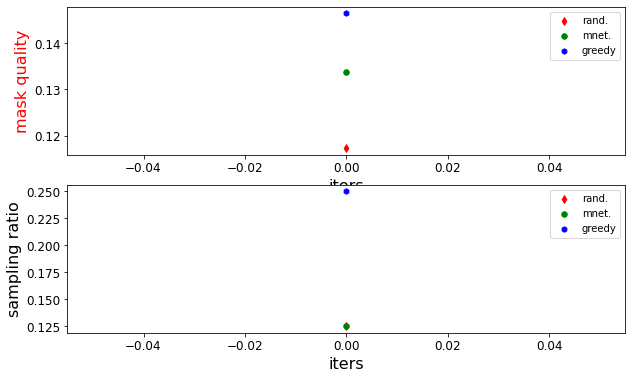


return at Iter:  50
loss of returned mask:  10.296498239040375
No change in row selections after 31 iters, ending iteration~

return at Iter:  30
loss of returned mask:  10.23867279291153
No change in row selections after 31 iters, ending iteration~

return at Iter:  30
loss of returned mask:  10.044583678245544
No change in row selections after 31 iters, ending iteration~

return at Iter:  30
loss of returned mask:  9.820694476366043
No change in row selections after 31 iters, ending iteration~

return at Iter:  30
loss of returned mask:  9.737808257341385
No change in row selections after 31 iters, ending iteration~

return at Iter:  30
loss of returned mask:  9.454168379306793
No change in row selections after 31 iters, ending iteration~

return at Iter:  30
loss of returned mask:  9.195497632026672
No change in row selections after 31 iters, ending iteration~

return at Iter:  30
loss of returned mask:  9.25365835428238
No change in row selections after 31 iters, ending iteration~

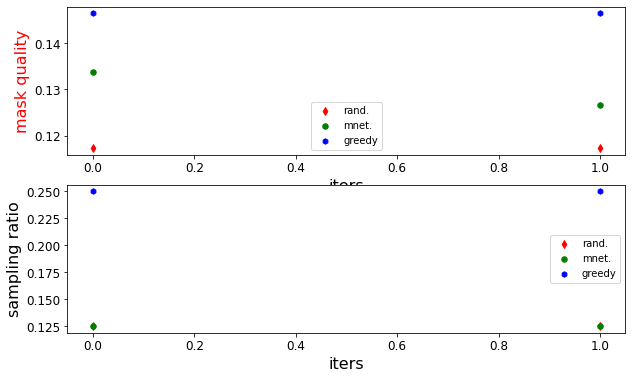

No change in row selections after 31 iters, ending iteration~

return at Iter:  30
loss of returned mask:  7.184107601642609
No change in row selections after 31 iters, ending iteration~

return at Iter:  30
loss of returned mask:  9.540994465351105
No change in row selections after 31 iters, ending iteration~

return at Iter:  30
loss of returned mask:  9.477130323648453
No change in row selections after 31 iters, ending iteration~

return at Iter:  30
loss of returned mask:  9.029272943735123
No change in row selections after 31 iters, ending iteration~

return at Iter:  30
loss of returned mask:  9.100015461444855
No change in row selections after 31 iters, ending iteration~

return at Iter:  30
loss of returned mask:  9.059474617242813
No change in row selections after 31 iters, ending iteration~

return at Iter:  30
loss of returned mask:  8.994152396917343
No change in row selections after 31 iters, ending iteration~

return at Iter:  30
loss of returned mask:  9.042402356863022


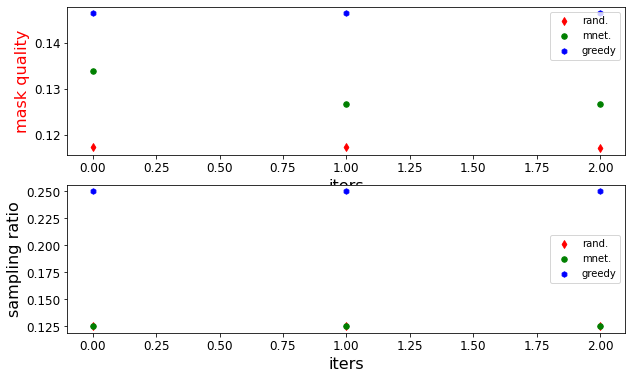

No further decrease in loss after 30 consecutive iters, ending iterations~ 

return at Iter:  30
loss of returned mask:  6.661268323659897
No change in row selections after 31 iters, ending iteration~

return at Iter:  30
loss of returned mask:  6.268510967493057
No further decrease in loss after 30 consecutive iters, ending iterations~ 

return at Iter:  30
loss of returned mask:  5.9466056525707245
No further decrease in loss after 30 consecutive iters, ending iterations~ 

return at Iter:  30
loss of returned mask:  11.439521610736847
No further decrease in loss after 30 consecutive iters, ending iterations~ 

return at Iter:  30
loss of returned mask:  11.586962640285492
No further decrease in loss after 30 consecutive iters, ending iterations~ 

return at Iter:  30
loss of returned mask:  11.879892647266388
No further decrease in loss after 30 consecutive iters, ending iterations~ 

return at Iter:  30
loss of returned mask:  11.783450841903687
No change in row selections after 31

KeyboardInterrupt: 

In [9]:
alternating_update_with_unetRecon(mnet,UNET,train_full,testimg,fullmask,\
                                  alpha=3e-4,c=1e-2,lr_mb=5e-4,lr_mn=1e-4,\
                                  maxIter_mb=50,maxRep=5,\
                                  corefreq=24,budget=16,\
                                  mask_greedy=mask_greedy,change_initmask=True,\
                                  verbose=False,plot=True,validate_every=50)

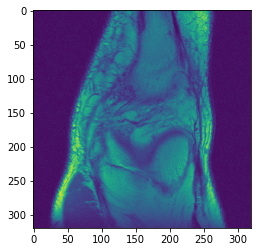

In [11]:
plt.imshow(train_full[0,:,:])
plt.show()

In [ ]:
reload(utils)
import mask_backward_new
reload(mask_backward_new)
from mask_backward_new import mask_backward
from utils import raw_normalize, visualization